In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from imports.data import CCV3
from torch_geometric.data import DataLoader 
from imports.models import Net_DE, Net_GAT, Net_Trans
from torch_geometric.nn import knn_graph

import numpy as np
import awkward as ak
import time
from imports.Agglomerative import Aggloremative

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
import pandas as pd

df_GAT = pd.read_csv("csvPion/df_GAT_pi_017.csv")
df_DE = pd.read_csv("csvPion/df_DE_pi_0175.csv")
df_Trans = pd.read_csv("csvPion/df_Trans_pi_016.csv")
df_Track = pd.read_csv("csvPion/df_TICL_Track_pion.csv")
df_MT = pd.read_csv("csvPion/df_TICL_MT_pion.csv")


In [11]:
df_DE

,event_index,cp_id,trackster_id,sim_to_reco_score,reco_to_sim_score,cp_raw_energy,cp_regressed_energy,trackster_energy,shared_energy,cp_eta
0,0,0,0,1.000000,1.000000,116.994710,171.000800,77.174009,0.000000,1.847672
1,0,0,1,0.999966,0.999408,116.994710,171.000800,22.122741,0.119212,1.847672
2,0,0,2,0.000034,0.589389,116.994710,171.000800,234.917335,116.875498,1.847672
3,0,0,3,1.000000,1.000000,116.994710,171.000800,11.406867,0.000000,1.847672
4,0,1,0,0.993429,0.995126,19.843769,38.141560,77.174009,0.833754,2.337873
...,...,...,...,...,...,...,...,...,...,...
94479,9835,0,0,0.000000,0.000000,13.079778,24.027498,13.079778,13.079778,1.671417
94480,9836,0,0,1.000000,1.000000,61.601587,85.841550,84.263519,0.000000,2.076053
94481,9836,0,1,0.000000,0.000000,61.601587,85.841550,61.601587,61.601587,2.076053
94482,9836,1,0,0.000002,0.000002,84.226280,105.712000,84.263519,84.226280,2.550753


In [3]:
def calculate_metrics(df, model_name):
    # Filter to only include rows with pgid == 211.
    #df = df[df['pgid'] == 211].copy()
    
    # ----- Efficiency Calculation -----
    # Step 1: Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()

    # Step 2: Group by 'event_index' and 'cp_id' to process each CaloParticle individually
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])

    # Step 3: For each CaloParticle, check if any 'shared_energy' >= 50% of 'cp_energy'
    def is_cp_associated(group):
        cp_energy = group['cp_raw_energy'].iloc[0]  # Assuming 'cp_energy' is consistent within the group
        threshold = 0.5 * cp_energy
        return (group['shared_energy'] >= threshold).any()

    # Apply the association function to each group
    cp_associated = cp_grouped.apply(is_cp_associated)

    # Step 4: Calculate the number of associated CaloParticles and total CaloParticles
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])

    # A Trackster is "associated" if reco_to_sim_score < 0.2 for at least one CP
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0

    # ----- Containment Calculation -----
    #  (similar approach, but now we look at Sim-to-Reco < 0.2)
    cp_valid_cont = df.dropna(subset=['cp_id']).copy()
    cp_grouped_cont = cp_valid_cont.groupby(['event_index', 'cp_id'])
    cp_associated_cont = cp_grouped_cont['sim_to_reco_score'].min() < 0.2
    num_associated_cp_cont = cp_associated_cont.sum()
    total_cp_cont = cp_associated_cont.count()
    containment = num_associated_cp_cont / total_cp_cont if total_cp_cont > 0 else 0

    # ----- Duplicate Rate -----
    # Number of simulated objects (CaloParticles) that have been associated (Sim-to-Reco < 0.2)
    # to multiple Tracksters, divided by the total number of simulated objects.
    cp_grouped_dup = cp_valid.groupby(['event_index', 'cp_id'])

    def get_associated_tracksters_cp(group):
        # Return the unique Trackster IDs for which sim_to_reco_score < 0.2
        return group[group['sim_to_reco_score'] < 0.2]['trackster_id'].unique()

    cp_associated_tracksters = cp_grouped_dup.apply(get_associated_tracksters_cp)

    # A CP is "duplicated" if it's associated with more than one Trackster
    duplicate_count = (cp_associated_tracksters.apply(lambda x: len(x) > 1)).sum()
    total_cp_dup = len(cp_associated_tracksters)
    duplicate_rate = duplicate_count / total_cp_dup if total_cp_dup > 0 else 0

    # ----- Merge Rate -----
    # Number of reconstructed objects (Tracksters) that have been associated (Reco-to-Sim < 0.2)
    # to multiple simulated objects, divided by the total number of reconstructed objects.
    tst_grouped_merge = tst_valid.groupby(['event_index', 'trackster_id'])

    def get_associated_cps_tst(group):
        # Return the unique CP IDs for which reco_to_sim_score < 0.2
        return group[group['reco_to_sim_score'] < 0.2]['cp_id'].unique()

    tst_associated_cps = tst_grouped_merge.apply(get_associated_cps_tst)

    # A Trackster is "merged" if it's associated with more than one CP
    merge_count = (tst_associated_cps.apply(lambda x: len(x) > 1)).sum()
    total_tst_merge = len(tst_associated_cps)
    merge_rate = merge_count / total_tst_merge if total_tst_merge > 0 else 0

    # Print results for the model
    print(f"\nModel: {model_name}")
    print(f"Efficiency:  {efficiency:.4f} ({num_associated_cp} / {total_cp})")
    print(f"Containment: {containment:.4f} ({num_associated_cp_cont} / {total_cp_cont})")
    print(f"Purity:      {purity:.4f} ({num_associated_tst} / {total_tst})")
    print(f"Duplicate Rate: {duplicate_rate:.4f} ({duplicate_count} CPs out of {total_cp_dup} total)")
    print(f"Merge Rate:     {merge_rate:.4f} ({merge_count} Tracksters out of {total_tst_merge} total)")
    print(f"Num tracksters ratio: {total_tst / total_cp if total_cp > 0 else 0:.4f}")

    return {
        'efficiency': efficiency,
        'purity': purity,
        'containment': containment,
        'duplicate_rate': duplicate_rate,
        'merge_rate': merge_rate
    }

# Example usage
our_model_metrics = calculate_metrics(df_GAT, "GAT Model")
de_model_metrics = calculate_metrics(df_DE, "DE Model")
trans_model_metrics = calculate_metrics(df_Trans, "Transformer Model")
track_model_metrics = calculate_metrics(df_Track, "CERN Tracksters")
mt_model_metrics = calculate_metrics(df_MT, "CERN Mixed Tracksters")




Model: GAT Model
Efficiency:  0.9984 (27965 / 28010)
Containment: 0.9386 (26289 / 28010)
Purity:      0.8826 (22732 / 25757)
Duplicate Rate: 0.0000 (0 CPs out of 28010 total)
Merge Rate:     0.0000 (0 Tracksters out of 25757 total)
Num tracksters ratio: 0.9196

Model: DE Model
Efficiency:  0.9979 (27951 / 28010)
Containment: 0.9436 (26429 / 28010)
Purity:      0.9033 (24719 / 27366)
Duplicate Rate: 0.0000 (0 CPs out of 28010 total)
Merge Rate:     0.0000 (0 Tracksters out of 27366 total)
Num tracksters ratio: 0.9770

Model: Transformer Model
Efficiency:  0.9987 (27974 / 28010)
Containment: 0.9459 (26496 / 28010)
Purity:      0.8940 (24623 / 27544)
Duplicate Rate: 0.0000 (0 CPs out of 28010 total)
Merge Rate:     0.0000 (0 Tracksters out of 27544 total)
Num tracksters ratio: 0.9834

Model: CERN Tracksters
Efficiency:  0.7064 (19745 / 27952)
Containment: 0.5316 (14859 / 27952)
Purity:      0.9695 (148952 / 153642)
Duplicate Rate: 0.0000 (0 CPs out of 27952 total)
Merge Rate:     0.0000 

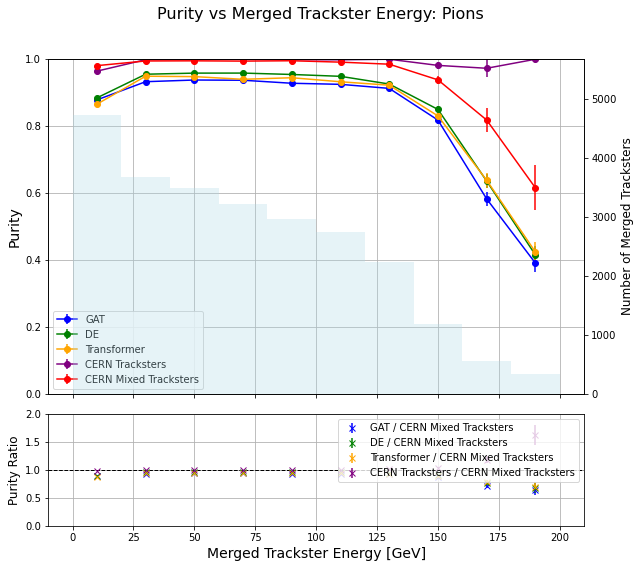

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df_GAT = pd.read_csv("csvPion/df_GAT_pi_017.csv")
df_DE = pd.read_csv("csvPion/df_DE_pi_0175.csv")
df_Trans = pd.read_csv("csvPion/df_Trans_pi_016.csv")
df_Track = pd.read_csv("csvPion/df_TICL_Track_pion.csv")
df_MT = pd.read_csv("csvPion/df_TICL_MT_pion.csv")

# ---------------------------------------
# Utility function: prepare trackster data
# ---------------------------------------
def prepare_trackster_data(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')
    
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Prepare all models
model_dfs = {
    'GAT': df_GAT,
    'DE': df_DE,
    'Transformer': df_Trans,
    'CERN Tracksters': df_Track,
    'CERN Mixed Tracksters': df_MT
}

prepared_dfs = {name: prepare_trackster_data(df) for name, df in model_dfs.items()}

# ---------------------------------------
# Define shared energy bins
# ---------------------------------------
# Get global min energy (across all models) for fair binning
all_energies = pd.concat([df['trackster_energy'] for df in prepared_dfs.values()])
min_energy = all_energies.min()
max_energy = 200
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bar_width = energy_bins[1] - energy_bins[0]

# Assign bins
for df in prepared_dfs.values():
    df['energy_bin'] = pd.cut(df['trackster_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ---------------------------------------
# Aggregate purity per energy bin
# ---------------------------------------
def aggregate_purity(df):
    agg = df.groupby('energy_bin').agg(
        total_ts=('trackster_energy', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg.set_index('energy_bin').reindex(range(n_bins)).reset_index()

agg_purities = {name: aggregate_purity(df) for name, df in prepared_dfs.items()}

# ---------------------------------------
# Plot
# ---------------------------------------
colors = {
    'GAT': 'blue',
    'DE': 'green',
    'Transformer': 'orange',
    'CERN Tracksters': 'purple',
    'CERN Mixed Tracksters': 'red'
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
plt.subplots_adjust(hspace=0.1)

# ---- Purity curves ----
for name, agg in agg_purities.items():
    ax1.errorbar(bin_centers, agg['purity'], yerr=agg['purity_error'],
                 marker='o', linestyle='-', color=colors[name], label=name)

ax1.set_ylabel('Purity', fontsize=14)
ax1.set_ylim(0,1)
ax1.legend()
ax1.grid(True)

# ---- Histogram (choose one model, e.g., GAT) ----
hist_model = 'GAT'
ax1_hist = ax1.twinx()
ax1_hist.bar(bin_centers, agg_purities[hist_model]['total_ts'], width=bar_width,
             color='lightblue', alpha=0.3, label=f'Trackster Count ({hist_model})')
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=12)
ax1_hist.set_ylim(0, agg_purities[hist_model]['total_ts'].max() * 1.2)

# ---- Ratio plot (GAT / others) ----
ref_model = 'CERN Mixed Tracksters'  # Reference in the denominator
ref_purity = agg_purities[ref_model]['purity']
ref_error = agg_purities[ref_model]['purity_error']

for name in agg_purities:
    if name == ref_model:
        continue
    num = agg_purities[name]['purity']
    err = agg_purities[name]['purity_error']
    ratio = num / ref_purity
    ratio_err = ratio * np.sqrt((err / num)**2 + (ref_error / ref_purity)**2)
    ax2.errorbar(bin_centers, ratio, yerr=ratio_err, fmt='x', label=f'{name} / {ref_model}',
                 color=colors[name], markersize=6)

ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Merged Trackster Energy [GeV]', fontsize=14)
ax2.set_ylabel('Purity Ratio', fontsize=12)
ax2.set_ylim(0.0, 2.0)
ax2.grid(True)
ax2.legend(fontsize=10)

plt.suptitle('Purity vs Merged Trackster Energy: Pions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


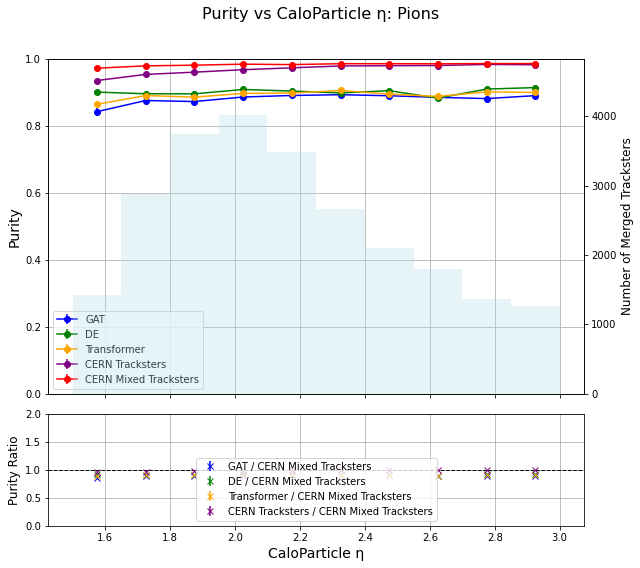

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df_GAT = pd.read_csv("csvPion/df_GAT_pi_017.csv")
df_DE = pd.read_csv("csvPion/df_DE_pi_0175.csv")
df_Trans = pd.read_csv("csvPion/df_Trans_pi_016.csv")
df_Track = pd.read_csv("csvPion/df_TICL_Track_pion.csv")
df_MT = pd.read_csv("csvPion/df_TICL_MT_pion.csv")

# ---------------------------------------
# Utility function: prepare trackster data
# ---------------------------------------
def prepare_trackster_data(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')
    df['cp_eta'] = pd.to_numeric(df['cp_eta'], errors='coerce')  # Use cp_eta instead of trackster_eta

    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',
        'cp_eta': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Prepare all models
model_dfs = {
    'GAT': df_GAT,
    'DE': df_DE,
    'Transformer': df_Trans,
    'CERN Tracksters': df_Track,
    'CERN Mixed Tracksters': df_MT
}

prepared_dfs = {name: prepare_trackster_data(df) for name, df in model_dfs.items()}

# ---------------------------------------
# Define shared η bins based on cp_eta
# ---------------------------------------
all_etas = pd.concat([df['cp_eta'] for df in prepared_dfs.values()])
min_eta = 1.5
max_eta = 3.0
n_eta_bins = 10
eta_bins = np.linspace(min_eta, max_eta, n_eta_bins + 1)
eta_centers = (eta_bins[:-1] + eta_bins[1:]) / 2
bar_width = eta_bins[1] - eta_bins[0]

# Assign bins
for df in prepared_dfs.values():
    df['eta_bin'] = pd.cut(df['cp_eta'], bins=eta_bins, labels=False, include_lowest=True)

# ---------------------------------------
# Aggregate purity per cp_eta bin
# ---------------------------------------
def aggregate_purity_eta(df):
    agg = df.groupby('eta_bin').agg(
        total_ts=('cp_eta', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg.set_index('eta_bin').reindex(range(n_eta_bins)).reset_index()

agg_purities_eta = {name: aggregate_purity_eta(df) for name, df in prepared_dfs.items()}

# ---------------------------------------
# Plot
# ---------------------------------------
colors = {
    'GAT': 'blue',
    'DE': 'green',
    'Transformer': 'orange',
    'CERN Tracksters': 'purple',
    'CERN Mixed Tracksters': 'red'
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
plt.subplots_adjust(hspace=0.1)

# ---- Purity curves ----
for name, agg in agg_purities_eta.items():
    ax1.errorbar(eta_centers, agg['purity'], yerr=agg['purity_error'],
                 marker='o', linestyle='-', color=colors[name], label=name)

ax1.set_ylabel('Purity', fontsize=14)
ax1.set_ylim(0,1)
ax1.legend()
ax1.grid(True)

# ---- Histogram (choose one model, e.g., GAT) ----
hist_model = 'GAT'
ax1_hist = ax1.twinx()
ax1_hist.bar(eta_centers, agg_purities_eta[hist_model]['total_ts'], width=bar_width,
             color='lightblue', alpha=0.3, label=f'Trackster Count ({hist_model})')
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=12)
ax1_hist.set_ylim(0, agg_purities_eta[hist_model]['total_ts'].max() * 1.2)

# ---- Ratio plot (vs CERN Mixed Tracksters) ----
ref_model = 'CERN Mixed Tracksters'
ref_purity = agg_purities_eta[ref_model]['purity']
ref_error = agg_purities_eta[ref_model]['purity_error']

for name in agg_purities_eta:
    if name == ref_model:
        continue
    num = agg_purities_eta[name]['purity']
    err = agg_purities_eta[name]['purity_error']
    ratio = num / ref_purity
    ratio_err = ratio * np.sqrt((err / num)**2 + (ref_error / ref_purity)**2)
    ax2.errorbar(eta_centers, ratio, yerr=ratio_err, fmt='x', label=f'{name} / {ref_model}',
                 color=colors[name], markersize=6)

ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('CaloParticle η', fontsize=14)
ax2.set_ylabel('Purity Ratio', fontsize=12)
ax2.set_ylim(0.0, 2.0)
ax2.grid(True)
ax2.legend(fontsize=10)

plt.suptitle('Purity vs CaloParticle η: Pions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


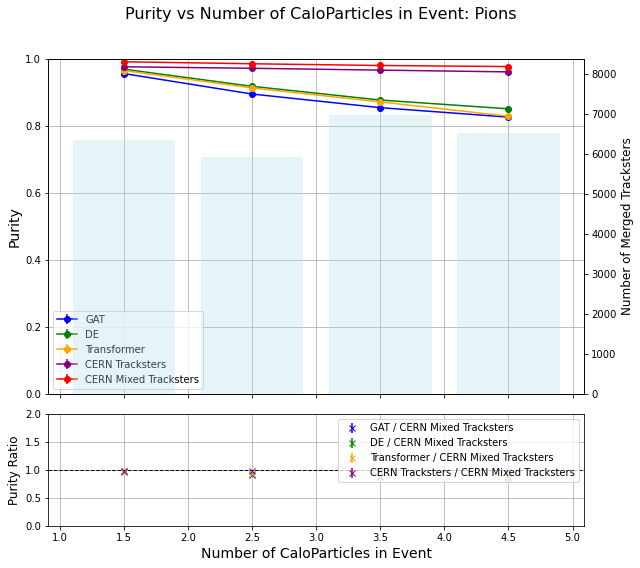

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df_GAT = pd.read_csv("csvPion/df_GAT_pi_017.csv")
df_DE = pd.read_csv("csvPion/df_DE_pi_0175.csv")
df_Trans = pd.read_csv("csvPion/df_Trans_pi_016.csv")
df_Track = pd.read_csv("csvPion/df_TICL_Track_pion.csv")
df_MT = pd.read_csv("csvPion/df_TICL_MT_pion.csv")

# ---------------------------------------
# Prepare per-trackster data with n_cps info
# ---------------------------------------
def prepare_trackster_data_with_n_cps(df):
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')

    # Count number of unique CPs in each event
    n_cp_per_event = df.groupby('event_index')['cp_id'].nunique().reset_index(name='n_cps')

    # Trackster-level grouping
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',
        'reco_to_sim_score': 'min'
    }).reset_index()

    # Associate with n_cps
    grouped = grouped.merge(n_cp_per_event, on='event_index', how='left')
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)

    return grouped

# Prepare all models
model_dfs = {
    'GAT': df_GAT,
    'DE': df_DE,
    'Transformer': df_Trans,
    'CERN Tracksters': df_Track,
    'CERN Mixed Tracksters': df_MT
}

prepared_dfs = {name: prepare_trackster_data_with_n_cps(df) for name, df in model_dfs.items()}

# ---------------------------------------
# Bin by number of CPs in the event
# ---------------------------------------
min_cps = 1
max_cps = 10
cp_bins = np.arange(min_cps, max_cps + 2)  # 1–10 inclusive
cp_centers = (cp_bins[:-1] + cp_bins[1:]) / 2
bar_width = 0.8

for df in prepared_dfs.values():
    df['ncp_bin'] = pd.cut(df['n_cps'], bins=cp_bins, labels=False, include_lowest=True)

# ---------------------------------------
# Aggregate purity by n_cps
# ---------------------------------------
def aggregate_purity_ncp(df):
    agg = df.groupby('ncp_bin').agg(
        total_ts=('trackster_energy', 'count'),
        assoc_ts=('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg.set_index('ncp_bin').reindex(range(len(cp_centers))).reset_index()

agg_purities_ncp = {name: aggregate_purity_ncp(df) for name, df in prepared_dfs.items()}

# ---------------------------------------
# Plot
# ---------------------------------------
colors = {
    'GAT': 'blue',
    'DE': 'green',
    'Transformer': 'orange',
    'CERN Tracksters': 'purple',
    'CERN Mixed Tracksters': 'red'
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
plt.subplots_adjust(hspace=0.1)

# ---- Purity curves ----
for name, agg in agg_purities_ncp.items():
    ax1.errorbar(cp_centers, agg['purity'], yerr=agg['purity_error'],
                 marker='o', linestyle='-', color=colors[name], label=name)

ax1.set_ylabel('Purity', fontsize=14)
ax1.set_ylim(0,1)
ax1.legend()
ax1.grid(True)

# ---- Histogram (choose one model, e.g., GAT) ----
hist_model = 'GAT'
ax1_hist = ax1.twinx()
ax1_hist.bar(cp_centers, agg_purities_ncp[hist_model]['total_ts'], width=bar_width,
             color='lightblue', alpha=0.3, label=f'Trackster Count ({hist_model})')
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=12)
ax1_hist.set_ylim(0, agg_purities_ncp[hist_model]['total_ts'].max() * 1.2)

# ---- Ratio plot (vs CERN Mixed Tracksters) ----
ref_model = 'CERN Mixed Tracksters'
ref_purity = agg_purities_ncp[ref_model]['purity']
ref_error = agg_purities_ncp[ref_model]['purity_error']

for name in agg_purities_ncp:
    if name == ref_model:
        continue
    num = agg_purities_ncp[name]['purity']
    err = agg_purities_ncp[name]['purity_error']
    ratio = num / ref_purity
    ratio_err = ratio * np.sqrt((err / num)**2 + (ref_error / ref_purity)**2)
    ax2.errorbar(cp_centers, ratio, yerr=ratio_err, fmt='x', label=f'{name} / {ref_model}',
                 color=colors[name], markersize=6)

ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Number of CaloParticles in Event', fontsize=14)
ax2.set_ylabel('Purity Ratio', fontsize=12)
ax2.set_ylim(0.0, 2.0)
ax2.grid(True)
ax2.legend(fontsize=10)

plt.suptitle('Purity vs Number of CaloParticles in Event: Pions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
